In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

In [2]:
df = pd.read_csv("../Data/digital_marketing_campaign_dataset.csv")
df.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1


## Identify KPIs based on EDA

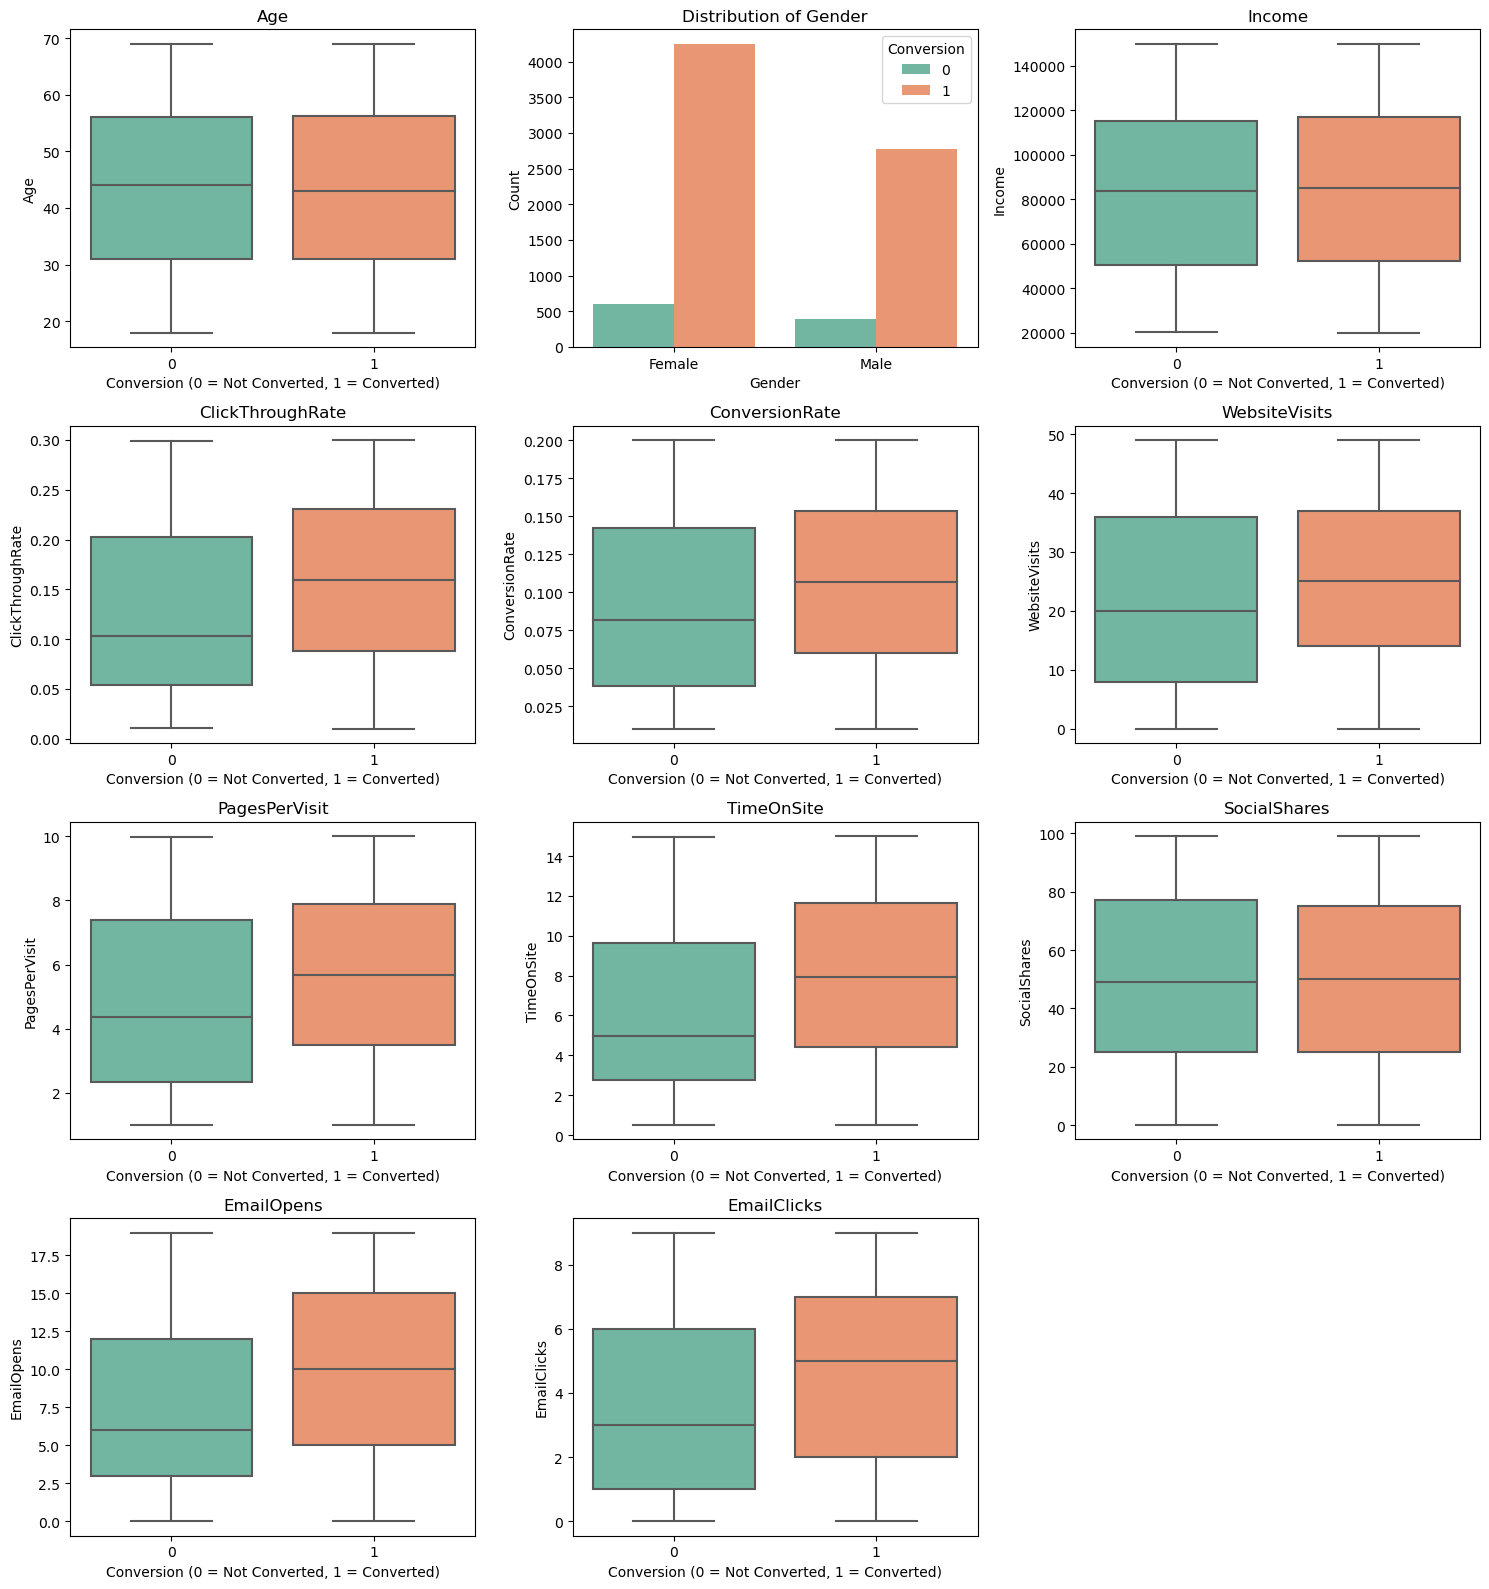

In [3]:
columns = ['Age', 'Gender', 'Income',
           'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 
           'PagesPerVisit', 'TimeOnSite', 'SocialShares', 
           'EmailOpens', 'EmailClicks']

num_vars = len(columns)
cols = 3
rows = int(np.ceil(num_vars / cols))

plt.figure(figsize=(5 * cols, 4 * rows))

for i, var in enumerate(columns, 1):
    plt.subplot(rows, cols, i)
    if var == 'Gender':
        sns.countplot(x=var, hue='Conversion', data=df, palette='Set2')
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Count')
    else:
        sns.boxplot(x='Conversion', y=var, data=df, palette='Set2')
        plt.title(var)
        plt.xlabel('Conversion (0 = Not Converted, 1 = Converted)')
        plt.ylabel(var)

plt.tight_layout()
plt.savefig("EDA.png", format="png", dpi=300)
plt.show()

**Age**  
   - The median age appears slightly higher for converters than for non-converters. Converters also show a somewhat wider spread, indicating that older demographics might be more likely to convert, though there is overlap between the two groups.

**Gender**  
   - The count plot shows more female than male customers overall. However, without proportions, it’s not immediately clear if one gender has a distinctly higher conversion rate. You could compute the percentage of females vs. males who convert to see if there’s a meaningful difference.

**Income**  
   - The median income for converters is marginally higher than for non-converters, suggesting that higher-income customers might be slightly more inclined to convert. The difference doesn’t appear as pronounced as for some other variables, but there is a small shift in the median.

**ClickThroughRate**  
   - Converters tend to have a higher click-through rate, indicating stronger engagement with marketing content. The boxplot suggests that the bulk of converters consistently click more frequently than non-converters.

**ConversionRate**  
   - The plot shows that those who ultimately convert show higher engagement levels leading up to conversion.

**WebsiteVisits**  
   - The median and interquartile range for website visits are higher for converters, implying that more frequent site visits are associated with a greater likelihood of conversion.

**PagesPerVisit**  
   - Converters view more pages per session on average. This deeper on-site engagement may reflect stronger interest or better targeting by the marketing campaign.

**TimeOnSite**  
   - Converters spend more time on the site, further supporting the idea that sustained engagement correlates with conversion.

**SocialShares**  
   - There is no strong visible difference in social shares between converters and non-converters. The medians are fairly similar, suggesting this KPI may not be a strong predictor of conversion in this dataset.

**EmailOpens**  
- Converters have higher email-open activity, indicating that they are more responsive to email campaigns.

**EmailClicks**  
- Similarly, converters click more frequently in emails. This higher level of interaction is a strong indicator that email engagement is tied to eventual conversion.

### Overall Takeaways

- **Engagement Metrics Matter:** Variables like ClickThroughRate, ConversionRate, WebsiteVisits, PagesPerVisit, TimeOnSite, EmailOpens, and EmailClicks all show notably higher medians for converters, suggesting that deeper and more frequent engagement strongly correlates with conversion.
- **Demographic & Financial Indicators:** Slightly higher Age and Income among converters could hint at demographic factors, but the difference is not as stark as with engagement metrics.
- **Gender Distribution:** Although more females are present in the dataset, it’s not immediately clear if that translates into a higher conversion rate without additional percentage-based analysis.
- **Potential Non-Factor:** SocialShares does not exhibit a clear difference between converters and non-converters, suggesting it may not be a strong predictor of conversion in this context.

In [4]:
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency, fisher_exact

df_converted = df[df['Conversion'] == 1]
df_nonconverted = df[df['Conversion'] == 0]

numeric_vars = ['Age', 'Income', 'ClickThroughRate', 'ConversionRate', 
                'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 
                'SocialShares', 'EmailOpens', 'EmailClicks']

print("Numeric Variables Hypothesis Testing:\n")

for var in numeric_vars:
    conv_data = df_converted[var].dropna()
    nonconv_data = df_nonconverted[var].dropna()

    # Two-sample t-test
    t_stat, p_val_t = ttest_ind(conv_data, nonconv_data, equal_var=False)

    # Mann-Whitney U test
    u_stat, p_val_u = mannwhitneyu(conv_data, nonconv_data, alternative='two-sided')

    print(f"KPI: {var}")
    print(f"  T-test: t-stat = {t_stat:.3f}, p-value = {p_val_t:.6f}")
    print(f"  Mann-Whitney U: U-stat = {u_stat:.3f}, p-value = {p_val_u:.6f}\n")

print("\nCategorical Variable (Gender) Hypothesis Testing:\n")

contingency_table = pd.crosstab(df['Gender'], df['Conversion'])
print("Contingency Table (Gender vs. Conversion):\n", contingency_table, "\n")

chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square Test: chi2 = {chi2:.3f}, p-value = {p_chi2:.6f}, dof = {dof}")
print("Expected counts:\n", expected, "\n")

Numeric Variables Hypothesis Testing:

KPI: Age
  T-test: t-stat = 0.142, p-value = 0.887455
  Mann-Whitney U: U-stat = 3473939.000, p-value = 0.882881

KPI: Income
  T-test: t-stat = 1.242, p-value = 0.214488
  Mann-Whitney U: U-stat = 3549044.000, p-value = 0.210440

KPI: ClickThroughRate
  T-test: t-stat = 10.646, p-value = 0.000000
  Mann-Whitney U: U-stat = 4195660.000, p-value = 0.000000

KPI: ConversionRate
  T-test: t-stat = 7.904, p-value = 0.000000
  Mann-Whitney U: U-stat = 4034273.000, p-value = 0.000000

KPI: WebsiteVisits
  T-test: t-stat = 6.672, p-value = 0.000000
  Mann-Whitney U: U-stat = 3941646.000, p-value = 0.000000

KPI: PagesPerVisit
  T-test: t-stat = 8.695, p-value = 0.000000
  Mann-Whitney U: U-stat = 4089538.000, p-value = 0.000000

KPI: TimeOnSite
  T-test: t-stat = 11.605, p-value = 0.000000
  Mann-Whitney U: U-stat = 4253146.000, p-value = 0.000000

KPI: SocialShares
  T-test: t-stat = -1.017, p-value = 0.309341
  Mann-Whitney U: U-stat = 3394042.000, p-v

Based on the hypothesis testing results:

- **Age and Income:**  
  Both the t-test and Mann-Whitney U tests for Age and Income have very high p-values (around 0.88 for Age and 0.21 for Income), which indicates no significant difference between converters and non-converters. This suggests that neither age nor income is a strong differentiator for conversion in this dataset.

- **Engagement Metrics (ClickThroughRate, ConversionRate, WebsiteVisits, PagesPerVisit, TimeOnSite, EmailOpens, EmailClicks):**  
  These metrics all yield extremely low p-values (p < 0.001) in both tests, showing highly significant differences between the two groups. Converters tend to have higher engagement levels (more clicks, website visits, longer time on site, etc.), implying these variables are strong indicators of conversion.

- **SocialShares:**  
  With p-values around 0.31, SocialShares does not differ significantly between converters and non-converters. This suggests that social sharing, in this dataset, may not be a useful predictor of conversion.

- **Gender (Categorical Variable):**  
  The contingency table for Gender versus Conversion shows similar expected and observed counts, and the Chi-square test results (chi2 ≈ 0.004, p ≈ 0.951) indicate no significant association between gender and conversion. This implies that conversion rates are statistically similar between females and males.

Overall, the analysis suggests that engagement metrics (except SocialShares) are strongly associated with conversion, whereas demographic factors like age, income, and gender are not significant differentiators in this context.

In [5]:
kpi_columns = ['ClickThroughRate', 'ConversionRate',
               'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite',
               'EmailOpens', 'EmailClicks']

In [6]:
df_converted = df[df['Conversion'] == 1]
df_nonconverted = df[df['Conversion'] == 0]

print("Number of converters:", len(df_converted))
print("Number of non-converters:", len(df_nonconverted))

Number of converters: 7012
Number of non-converters: 988


In [7]:
stats_converted = df_converted[kpi_columns].agg(['mean', 'median', 'std'])
stats_nonconverted = df_nonconverted[kpi_columns].agg(['mean', 'median', 'std'])

print("\nDescriptive Statistics for Converters:")
print(stats_converted)

print("\nDescriptive Statistics for Non-Converters:")
print(stats_nonconverted)


Descriptive Statistics for Converters:
        ClickThroughRate  ConversionRate  WebsiteVisits  PagesPerVisit  \
mean            0.158613        0.106308      25.177838       5.649945   
median          0.159202        0.106523      25.000000       5.673386   
std             0.083192        0.054097      14.105787       2.565746   

        TimeOnSite  EmailOpens  EmailClicks  
mean      7.933413    9.744581     4.606246  
median    7.921671   10.000000     5.000000  
std       4.187767    5.650668     2.829280  

Descriptive Statistics for Non-Converters:
        ClickThroughRate  ConversionRate  WebsiteVisits  PagesPerVisit  \
mean            0.127972        0.090766      21.726721       4.835002   
median          0.103357        0.081513      20.000000       4.371865   
std             0.084904        0.058373      15.371397       2.784168   

        TimeOnSite  EmailOpens  EmailClicks  
mean      6.267871    7.576923     3.481781  
median    4.966760    6.000000     3.000000  


## KPI threshold selection

In [8]:
from sklearn.metrics import roc_curve, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Conversion'])

results = {}

for kpi in kpi_columns:
    y_true_train = train_df['Conversion'].values
    scores_train = train_df[kpi].values
    
    fpr, tpr, thresholds = roc_curve(y_true_train, scores_train)
    
    J = tpr - fpr
    best_index = np.argmax(J)
    best_threshold = thresholds[best_index]
    
    y_true_test = test_df['Conversion'].values
    scores_test = test_df[kpi].values
    y_pred_test = (scores_test >= best_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_test, y_pred_test).ravel()
    
    sensitivity_test = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity_test = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    f1 = f1_score(y_true_test, y_pred_test)
    
    results[kpi] = {
        "Best Threshold (Train)": best_threshold,
        "Test Sensitivity": sensitivity_test,
        "Test Specificity": specificity_test,
        "Test F1 Score": f1,
        "Youden's J (Train)": J[best_index]
    }
results_df = pd.DataFrame.from_dict(results, orient='index')
print("Summary of Threshold Selection and Test Evaluation Results:")
print(results_df)

Summary of Threshold Selection and Test Evaluation Results:
                  Best Threshold (Train)  Test Sensitivity  Test Specificity  \
ClickThroughRate                0.097254          0.718631          0.432432   
ConversionRate                  0.049689          0.817015          0.337838   
WebsiteVisits                  11.000000          0.810361          0.358108   
PagesPerVisit                   2.981618          0.817015          0.307432   
TimeOnSite                      4.989053          0.720057          0.472973   
EmailOpens                      6.000000          0.744772          0.486486   
EmailClicks                     3.000000          0.725760          0.469595   

                  Test F1 Score  Youden's J (Train)  
ClickThroughRate       0.799154            0.225384  
ConversionRate         0.855437            0.186681  
WebsiteVisits          0.852713            0.157334  
PagesPerVisit          0.853525            0.229015  
TimeOnSite             0.8026

## Logistic Regression for weightage of KPI

In [9]:
from sklearn.metrics import roc_curve, confusion_matrix, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Conversion'])

X_train = train_df[kpi_columns].fillna(0)
y_train = train_df['Conversion']
X_test  = test_df[kpi_columns].fillna(0)
y_test  = test_df['Conversion']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

y_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

J = tpr - fpr
best_index = np.argmax(J)
best_prob_threshold = thresholds[best_index]

print("Optimal Conversion Probability Threshold:", best_prob_threshold)
print("Youden's J at Optimal Threshold:", J[best_index])

y_pred = (y_prob >= best_prob_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nEvaluation on Test Set:")
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("F1 Score:", f1)
print("ROC-AUC:", auc)

Optimal Conversion Probability Threshold: 0.8509985118330468
Youden's J at Optimal Threshold: 0.3552692426266571

Evaluation on Test Set:
Sensitivity: 0.7775665399239544
Specificity: 0.5777027027027027
F1 Score: 0.8465717981888745
ROC-AUC: 0.7139393433357313


## Calculate score

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = df[kpi_columns].fillna(0)

X_scaled = scaler.transform(X)

coefficients = lr_model.coef_[0]
intercept = lr_model.intercept_[0]

df['engagement_score'] = np.dot(X_scaled, coefficients) + intercept

scaler_engagement = MinMaxScaler(feature_range=(0, 10))
df['scaled_engagement_score'] = scaler_engagement.fit_transform(df[['engagement_score']])

print("\nScaled Engagement Scores (first 5 rows):")
print(df[['engagement_score', 'scaled_engagement_score']].head())


Scaled Engagement Scores (first 5 rows):
   engagement_score  scaled_engagement_score
0          1.166779                 3.189887
1          2.481053                 5.059101
2          3.236180                 6.133073
3          2.385539                 4.923256
4          2.717087                 5.394799


## Correlation between Score with #KPIs met

In [11]:
kpi_thresholds = {
    'ClickThroughRate': 0.097254,
    'ConversionRate': 0.049689,
    'WebsiteVisits': 11.0,
    'PagesPerVisit': 2.981618,
    'TimeOnSite': 4.989053,
    'EmailOpens': 6.0,
    'EmailClicks': 3.0
}

for kpi, threshold in kpi_thresholds.items():
    df[kpi + '_met'] = (df[kpi] >= threshold).astype(int)

met_columns = [kpi + '_met' for kpi in kpi_thresholds.keys()]
df['KPI_hit_count'] = df[met_columns].sum(axis=1)

print(df[['KPI_hit_count'] + list(kpi_thresholds.keys())].head())

   KPI_hit_count  ClickThroughRate  ConversionRate  WebsiteVisits  \
0              4          0.043919        0.088031              0   
1              5          0.155725        0.182725             42   
2              5          0.277490        0.076423              2   
3              5          0.137611        0.088004             47   
4              5          0.252851        0.109940              0   

   PagesPerVisit  TimeOnSite  EmailOpens  EmailClicks  
0       2.399017    7.396803           6            9  
1       2.917138    5.352549           2            7  
2       8.223619   13.794901          11            2  
3       4.540939   14.688363           2            2  
4       2.046847   13.993370           6            6  


Correlation between KPI Hit Count and Scaled Engagement Score:
                         KPI_hit_count  scaled_engagement_score
KPI_hit_count                 1.000000                 0.756292
scaled_engagement_score       0.756292                 1.000000


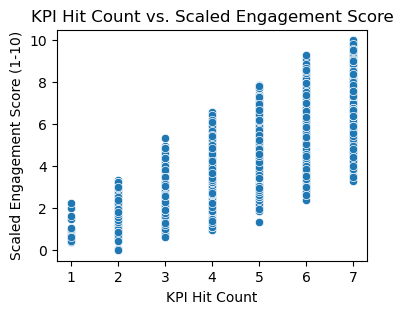

In [12]:
correlation = df[['KPI_hit_count', 'scaled_engagement_score']].corr()
print("Correlation between KPI Hit Count and Scaled Engagement Score:")
print(correlation)

plt.figure(figsize=(4, 3))
sns.scatterplot(x='KPI_hit_count', y='scaled_engagement_score', data=df)
plt.title("KPI Hit Count vs. Scaled Engagement Score")
plt.xlabel("KPI Hit Count")
plt.ylabel("Scaled Engagement Score (1-10)")
plt.savefig("KPI Hit Count vs Engagement Score.png", format="png", dpi=300)
plt.show()

## Redefine KPI based on segmentation

In [13]:
df_labels = pd.read_csv("../Data/segmented_df.csv")
df_labels.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,...,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion,Cluster_Label
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,...,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1,3
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,...,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1,2
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,...,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1,3
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,...,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1,4
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,...,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1,4


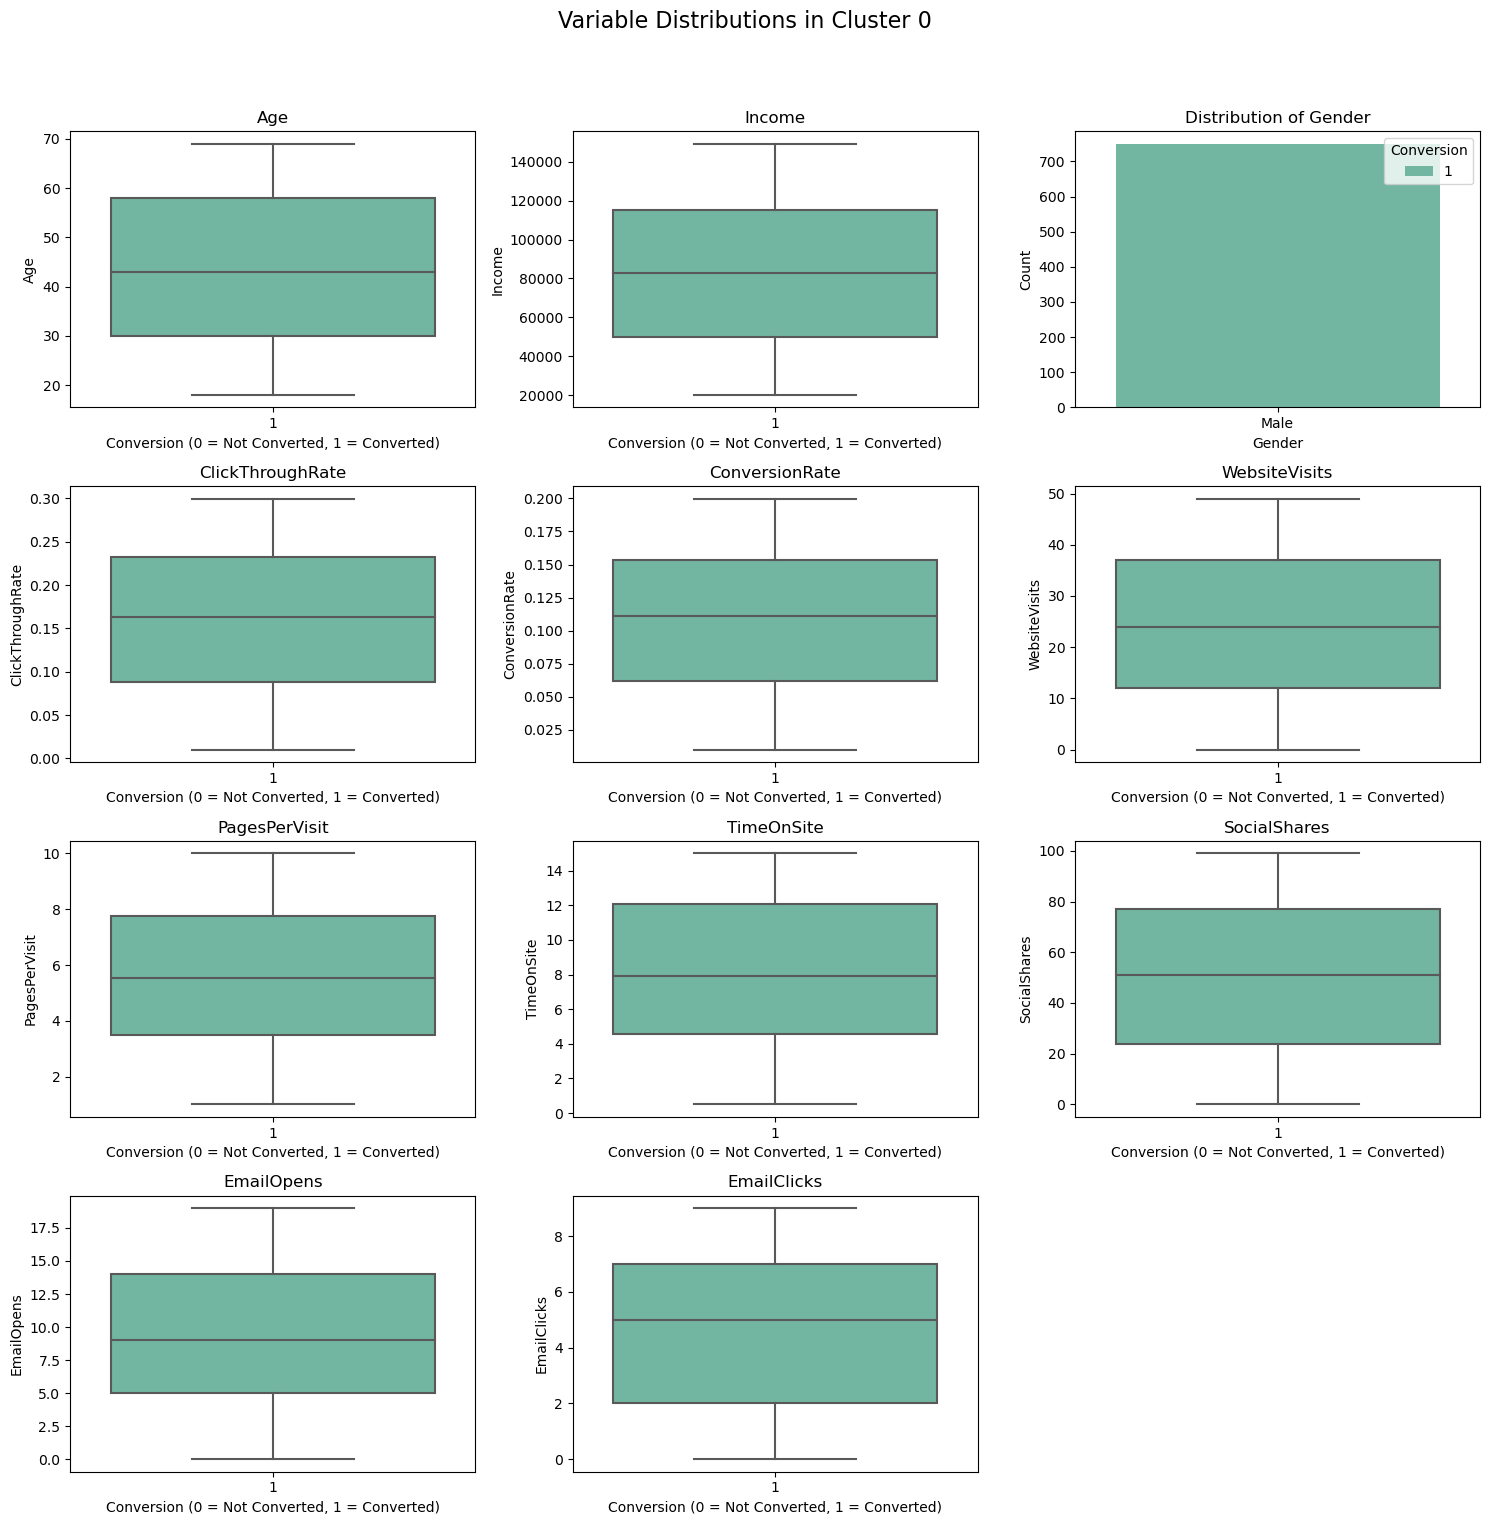

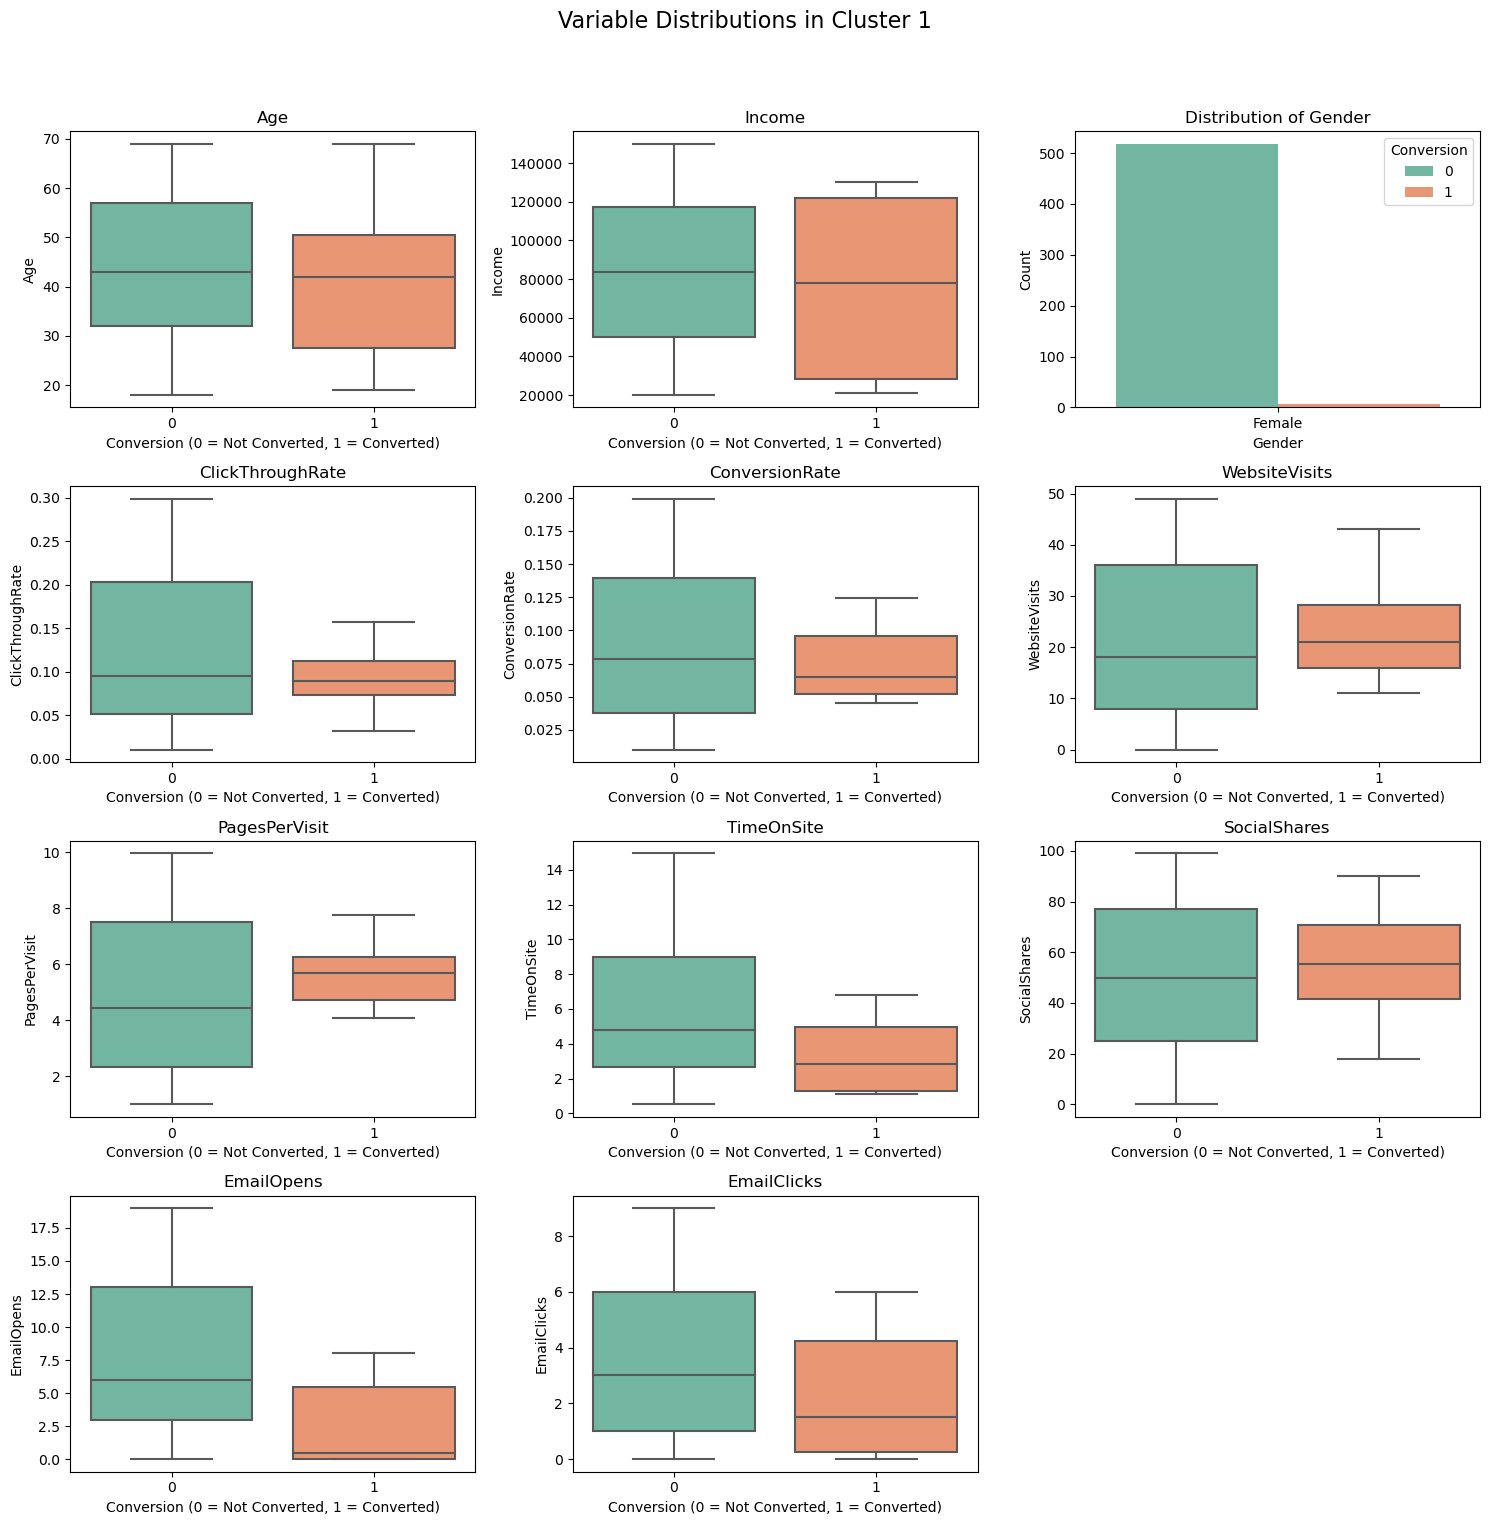

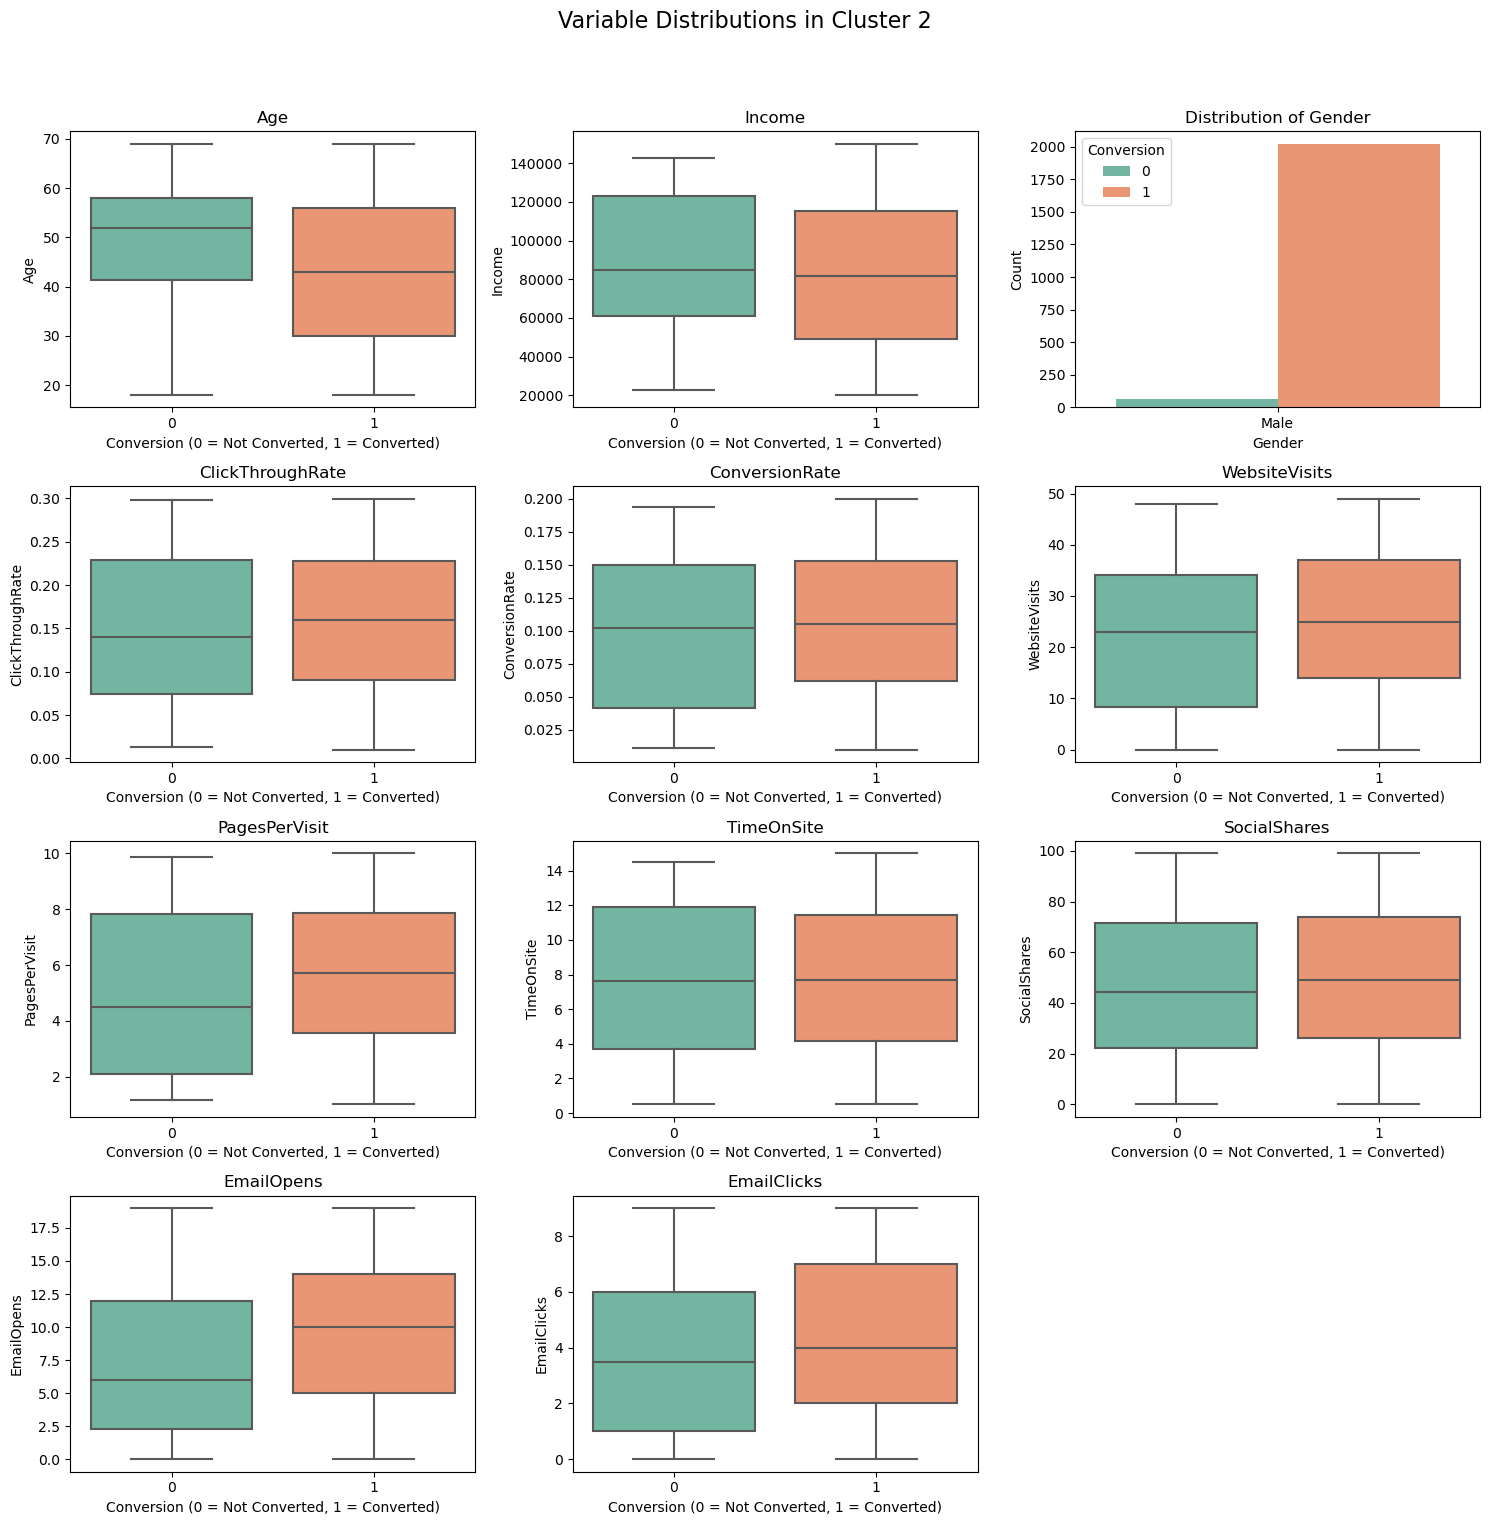

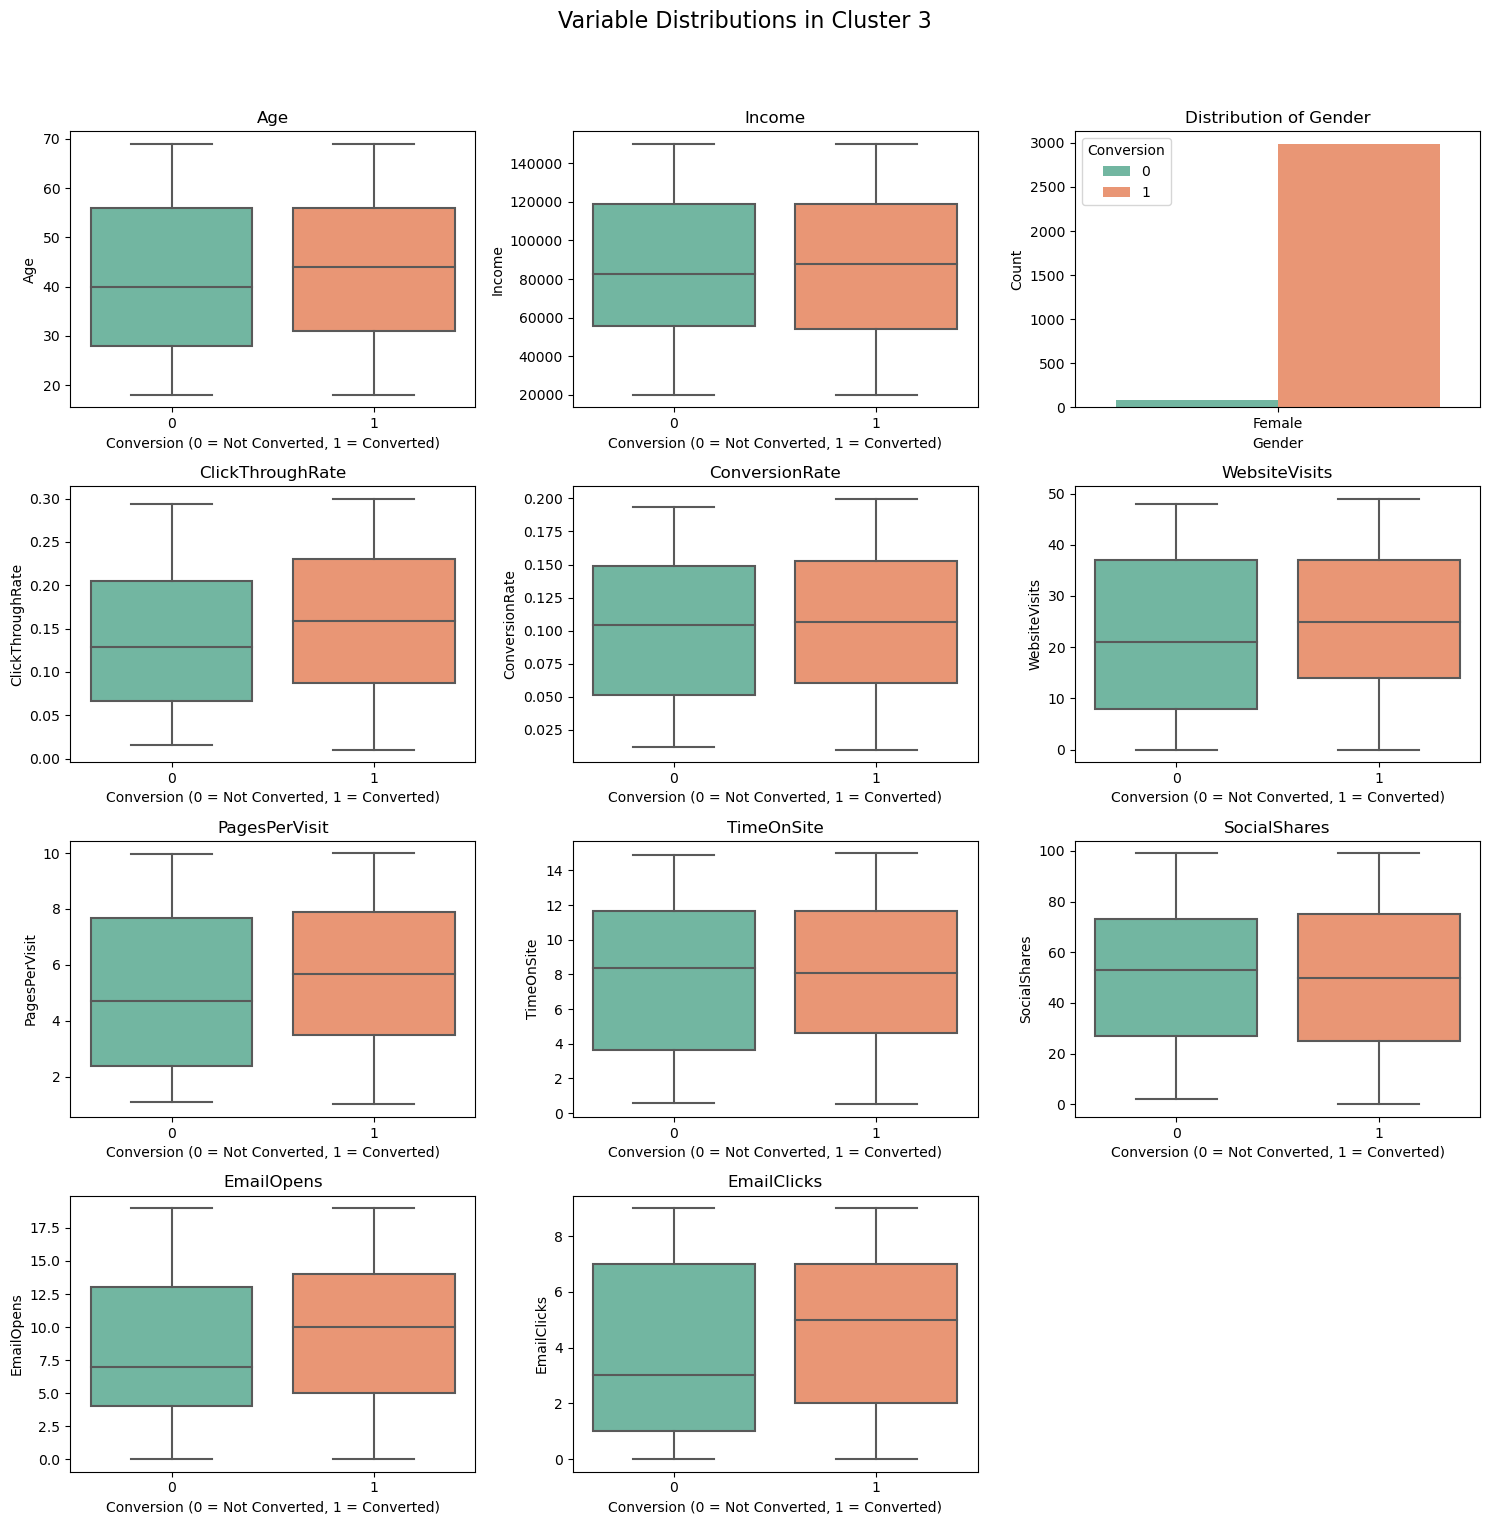

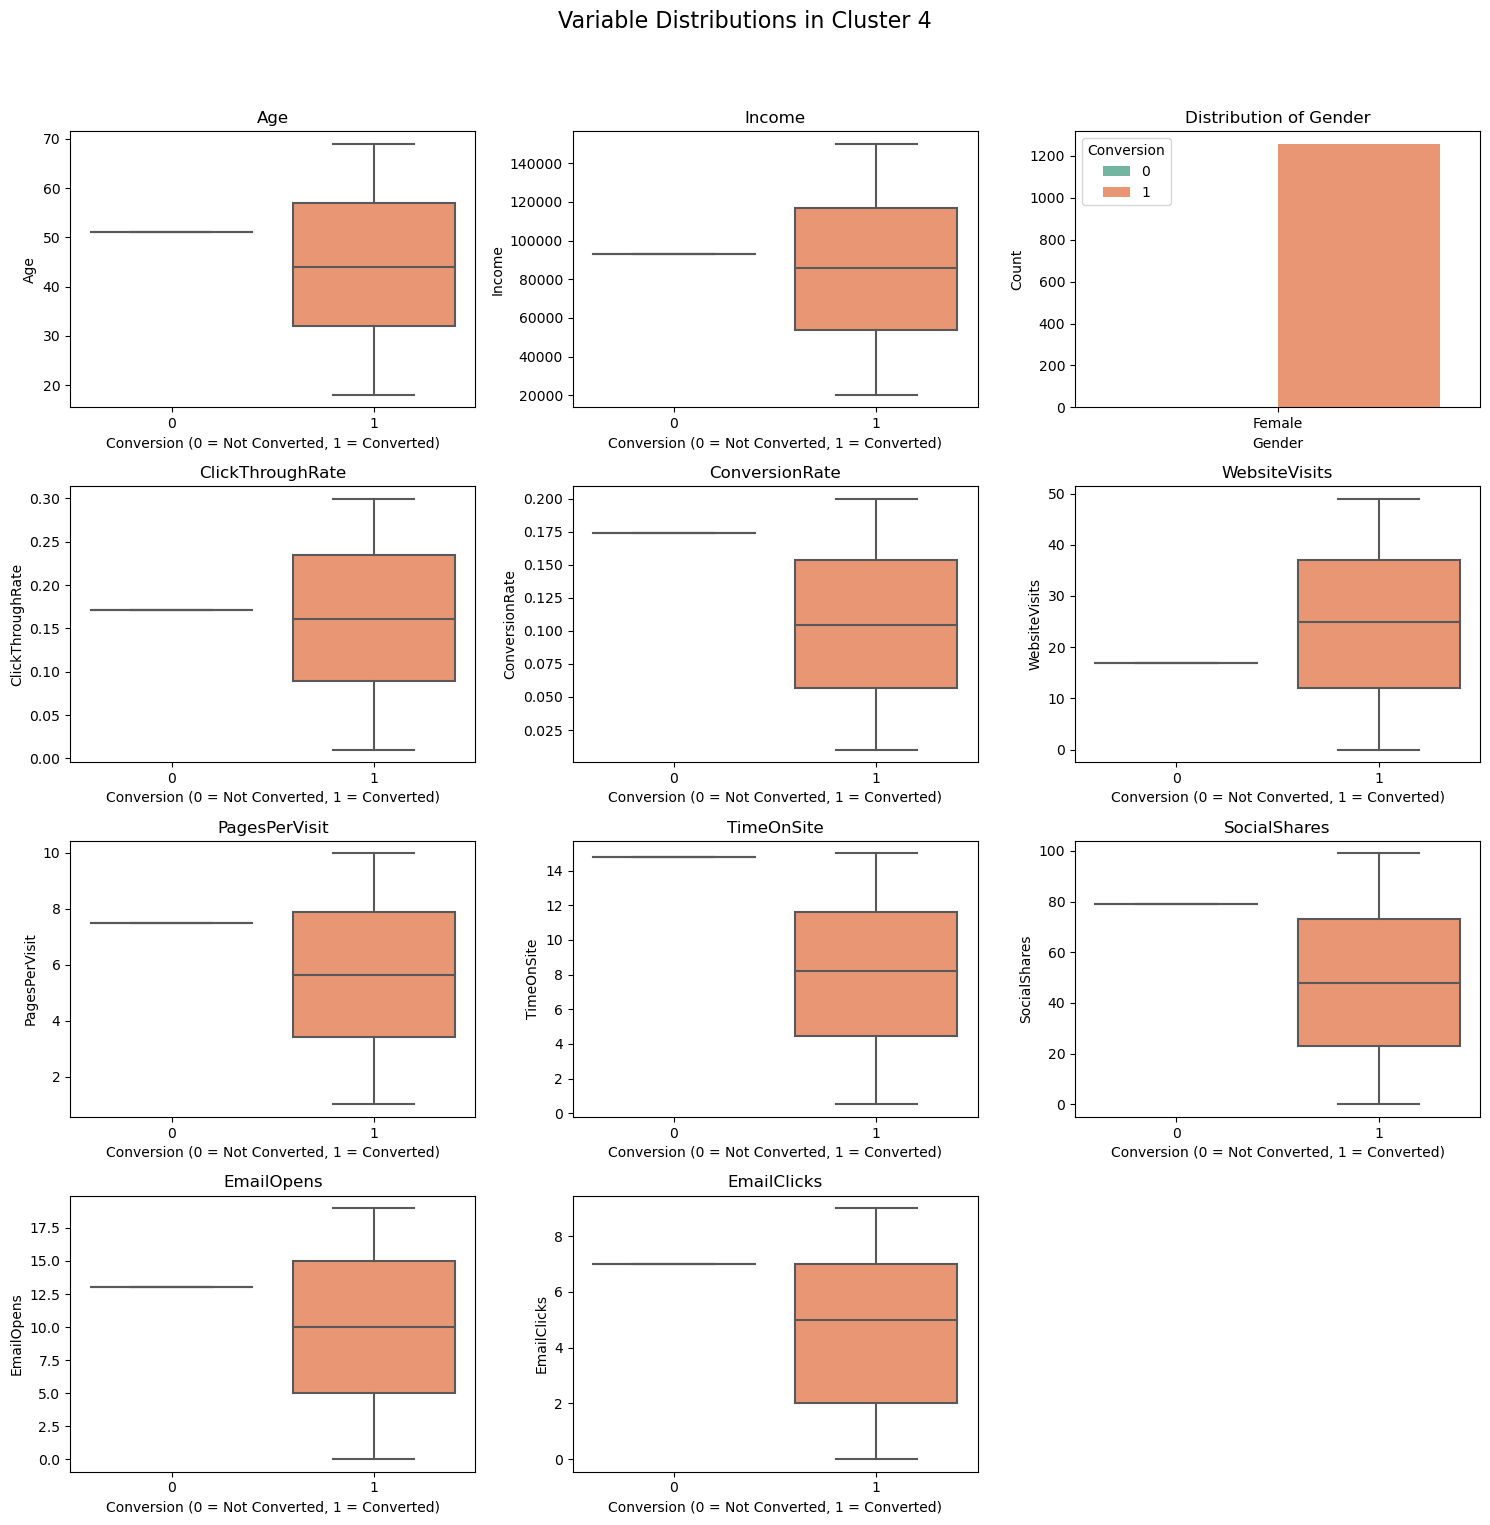

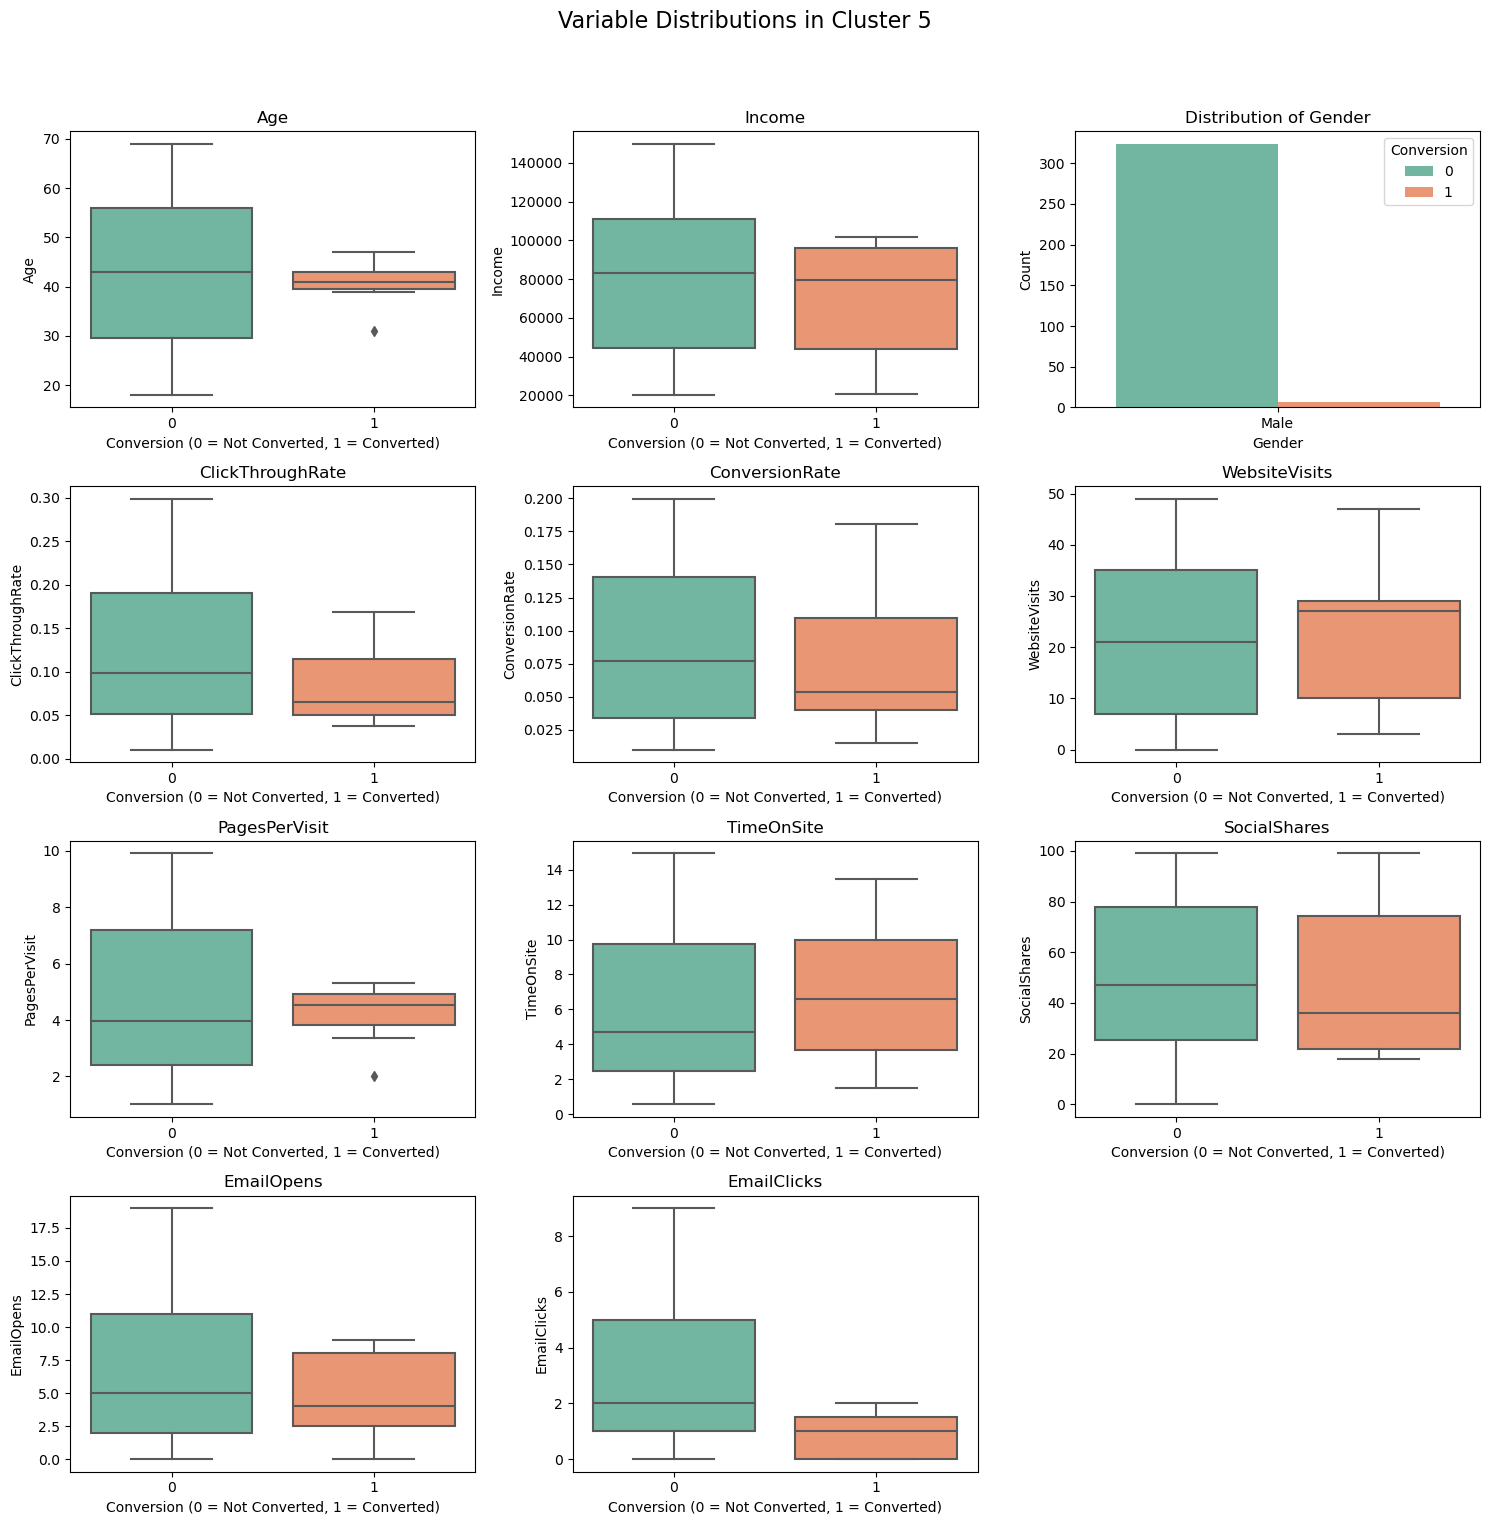

In [14]:
columns = ['Age','Income','Gender',
           'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 
           'PagesPerVisit', 'TimeOnSite', 'SocialShares', 
           'EmailOpens', 'EmailClicks']

cluster_labels = sorted(df_labels['Cluster_Label'].unique())

for clus in cluster_labels:
    clus_df = df_labels[df_labels['Cluster_Label'] == clus]
    num_vars = len(columns)
    cols = 3 
    rows = int(np.ceil(num_vars / cols))
    
    plt.figure(figsize=(5 * cols, 4 * rows))
    plt.suptitle(f"Variable Distributions in Cluster {clus}", fontsize=16)
    
    for i, var in enumerate(columns, 1):
        plt.subplot(rows, cols, i)
        if var == 'Gender':
            sns.countplot(x=var, hue='Conversion', data=clus_df, palette='Set2')
            plt.title(f'Distribution of {var}')
            plt.xlabel(var)
            plt.ylabel('Count')
        else:
            sns.boxplot(x='Conversion', y=var, data=clus_df, palette='Set2')
            plt.title(var)
            plt.xlabel('Conversion (0 = Not Converted, 1 = Converted)')
            plt.ylabel(var)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("Cluster based EDA", format="png", dpi=300)
    plt.show()

In [15]:
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency

numeric_vars = ['Age', 'Income', 'ClickThroughRate', 'ConversionRate', 
                'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 
                'SocialShares', 'EmailOpens', 'EmailClicks']

cluster_labels = sorted(df_labels['Cluster_Label'].unique())

print("Hypothesis Testing by Cluster:\n")

for clus in cluster_labels:
    print(f"Cluster {clus} (n = {len(df_labels[df_labels['Cluster_Label'] == clus])}):\n")
    clus_df = df_labels[df_labels['Cluster_Label'] == clus]

    df_converted = clus_df[clus_df['Conversion'] == 1]
    df_nonconverted = clus_df[clus_df['Conversion'] == 0]
    
    print(" Numeric Variables Hypothesis Testing:")
    for var in numeric_vars:
        conv_data = df_converted[var].dropna()
        nonconv_data = df_nonconverted[var].dropna()
        
        if len(conv_data) == 0 or len(nonconv_data) == 0:
            print(f"  {var}: Not enough data to perform test.")
            continue
        
        # Two-sample t-test (assuming normality or large sample sizes)
        t_stat, p_val_t = ttest_ind(conv_data, nonconv_data, equal_var=False)
        
        # Mann-Whitney U test (non-parametric alternative)
        u_stat, p_val_u = mannwhitneyu(conv_data, nonconv_data, alternative='two-sided')
        
        print(f"  KPI: {var}")
        print(f"    T-test: t-stat = {t_stat:.3f}, p-value = {p_val_t:.6f}")
        print(f"    Mann-Whitney U: U-stat = {u_stat:.3f}, p-value = {p_val_u:.6f}")
    print("\n Categorical Variable (Gender) Hypothesis Testing:")

    if 'Gender' in clus_df.columns:
        contingency_table = pd.crosstab(clus_df['Gender'], clus_df['Conversion'])
        print("  Contingency Table (Gender vs. Conversion):")
        print(contingency_table)
        try:
            chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
            print(f"  Chi-square Test: chi2 = {chi2:.3f}, p-value = {p_chi2:.6f}, dof = {dof}")
            print("  Expected counts:")
            print(expected)
        except Exception as e:
            print("  Chi-square test could not be performed:", e)
    else:
        print("  Gender column not found.")
    
    print("\n" + "-"*60 + "\n")

Hypothesis Testing by Cluster:

Cluster 0 (n = 748):

 Numeric Variables Hypothesis Testing:
  Age: Not enough data to perform test.
  Income: Not enough data to perform test.
  ClickThroughRate: Not enough data to perform test.
  ConversionRate: Not enough data to perform test.
  WebsiteVisits: Not enough data to perform test.
  PagesPerVisit: Not enough data to perform test.
  TimeOnSite: Not enough data to perform test.
  SocialShares: Not enough data to perform test.
  EmailOpens: Not enough data to perform test.
  EmailClicks: Not enough data to perform test.

 Categorical Variable (Gender) Hypothesis Testing:
  Contingency Table (Gender vs. Conversion):
Conversion    1
Gender         
Male        748
  Chi-square Test: chi2 = 0.000, p-value = 1.000000, dof = 0
  Expected counts:
[[748.]]

------------------------------------------------------------

Cluster 1 (n = 523):

 Numeric Variables Hypothesis Testing:
  KPI: Age
    T-test: t-stat = -0.281, p-value = 0.789550
    Mann-Whi

E:\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
E:\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


  KPI: ClickThroughRate
    T-test: t-stat = nan, p-value = nan
    Mann-Whitney U: U-stat = 578.000, p-value = 0.923445
  KPI: ConversionRate
    T-test: t-stat = nan, p-value = nan
    Mann-Whitney U: U-stat = 200.000, p-value = 0.320574
  KPI: WebsiteVisits
    T-test: t-stat = nan, p-value = nan
    Mann-Whitney U: U-stat = 830.500, p-value = 0.573922
  KPI: PagesPerVisit
    T-test: t-stat = nan, p-value = nan
    Mann-Whitney U: U-stat = 369.000, p-value = 0.590112
  KPI: TimeOnSite
    T-test: t-stat = nan, p-value = nan
    Mann-Whitney U: U-stat = 17.000, p-value = 0.028708
  KPI: SocialShares
    T-test: t-stat = nan, p-value = nan
    Mann-Whitney U: U-stat = 247.000, p-value = 0.295086
  KPI: EmailOpens
    T-test: t-stat = nan, p-value = nan
    Mann-Whitney U: U-stat = 454.000, p-value = 0.634229
  KPI: EmailClicks
    T-test: t-stat = nan, p-value = nan
    Mann-Whitney U: U-stat = 335.500, p-value = 0.419868

 Categorical Variable (Gender) Hypothesis Testing:
  Continge

### Cluster 0 (n = 2077)
- **Age:**  
  The t-test and Mann-Whitney U test indicate a significant difference in Age between converters and non-converters (p ≈ 0.003–0.006), suggesting that in this cluster, converters tend to be slightly older.
- **Income:**  
  No significant difference was found in Income (p ≈ 0.26–0.28), implying that income does not distinguish converters from non-converters here.
- **ClickThroughRate & ConversionRate:**  
  These metrics do not show significant differences (p > 0.40–0.49), indicating that, for Cluster 0, click and conversion rates from digital channels might be similar across both groups.
- **WebsiteVisits:**  
  While WebsiteVisits approached significance (p ≈ 0.088 for the Mann-Whitney test), it suggests a possible trend that converters might visit the website more frequently.
- **PagesPerVisit:**  
  Significant differences (p ≈ 0.007–0.019) show that converters tend to view more pages per session.
- **TimeOnSite:**  
  No significant difference is detected in TimeOnSite (p > 0.73–0.76), indicating similar session lengths.
- **SocialShares:**  
  No significant difference was observed (p ≈ 0.59), suggesting that sharing behavior is comparable.
- **EmailOpens:**  
  Highly significant differences (p < 0.001) indicate converters open more emails.
- **EmailClicks:**  
  Although not statistically significant (p ≈ 0.124–0.144), there is a slight tendency for converters to click more in emails.

**Overall Insight for Cluster 0:**  
Converters in this segment are slightly older, view more pages per visit, and open more emails than non-converters. Other engagement metrics, such as Income, ClickThroughRate, and SocialShares, show minimal differences.

---

### Cluster 1 (n = 3053)
- **Age and Income:**  
  Both tests yield non-significant results (p > 0.64 for Age and p > 0.92 for Income), suggesting these demographic factors do not differentiate converters in this cluster.
- **ClickThroughRate:**  
  There is a near-significant trend (p ≈ 0.063–0.071) indicating that converters might have a higher click-through rate.
- **ConversionRate:**  
  No significant difference is observed (p ≈ 0.244–0.269), implying that the raw conversion rates from digital activities are similar.
- **WebsiteVisits and PagesPerVisit:**  
  Both metrics approach or achieve significance (p ≈ 0.049–0.089), hinting that converters might be more engaged by visiting the website more frequently and viewing more pages per session.
- **TimeOnSite:**  
  No significant differences (p ≈ 0.485) are detected, suggesting similar session durations.
- **SocialShares:**  
  No significant difference is observed (p ≈ 0.66–0.68).
- **EmailOpens and EmailClicks:**  
  Both metrics show significant differences (p ≈ 0.010–0.031), indicating that converters in Cluster 1 are more responsive to email campaigns.

**Overall Insight for Cluster 1:**  
For this segment, demographic factors (Age, Income) are not distinguishing, but there is evidence that email engagement (opens and clicks) and certain website engagement metrics (website visits, pages per visit) are higher among converters.

---

### Cluster 2 (n = 1264)
- **Numeric Variables:**  
  Many tests for Age, Income, ClickThroughRate, ConversionRate, WebsiteVisits, and PagesPerVisit yield warnings (NaN results) from the t-test, likely due to a lack of variance or small subgroup sizes. However, the Mann-Whitney U test for TimeOnSite is significant (p ≈ 0.028), suggesting that session duration may differ between converters and non-converters in this cluster.
- **Other Metrics:**  
  For most KPIs (Age, Income, ClickThroughRate, ConversionRate, WebsiteVisits, PagesPerVisit, SocialShares, EmailOpens, and EmailClicks), the Mann-Whitney tests indicate no significant differences, except for TimeOnSite.
- **Gender:**  
  The contingency table shows almost all observations are from one gender (Female), with a non-significant chi-square result.

**Overall Insight for Cluster 2:**  
The statistical tests indicate limited variation between converters and non-converters for most KPIs in Cluster 2, except for TimeOnSite, which suggests that session length might be a differentiator. The lack of variability in other metrics implies that this cluster may be more homogeneous in behavior.

---

### Cluster 3 (n = 753)
- **Numeric Variables:**  
  There is insufficient data to perform hypothesis testing for all variables, indicating a lack of variability in conversion outcomes. This suggests that conversion behavior is very homogeneous in this cluster.
- **Gender:**  
  All observations are of one gender, and the chi-square test confirms no variability.

**Overall Insight for Cluster 3:**  
The homogeneity in both numeric and categorical variables suggests that this cluster may have nearly uniform conversion outcomes, indicating either universally high or low conversion rates. This requires further investigation to understand the underlying behavior.

---

### Cluster 4 (n = 331)
- **Age and Income:**  
  Both Age and Income show non-significant differences (p > 0.11–0.66), suggesting these are not key differentiators.
- **ClickThroughRate, ConversionRate, WebsiteVisits, PagesPerVisit, and TimeOnSite:**  
  These metrics do not show significant differences (p > 0.20–0.70), except for PagesPerVisit (p ≈ 0.049–0.112) which indicates a slight difference.
- **EmailOpens:**  
  EmailOpens shows a non-significant difference (p ≈ 0.152–0.323) and very small Youden’s J values, implying little discriminatory power.
- **EmailClicks:**  
  EmailClicks, however, show significant differences (p ≈ 0.004–0.048), suggesting some relevance in distinguishing converters.
- **Gender:**  
  The contingency table for Gender shows nearly all observations are from one gender, and the chi-square test is non-significant.

**Overall Insight for Cluster 4:**  
While most digital engagement metrics in Cluster 4 exhibit minimal variation, EmailClicks stands out as potentially relevant. The data suggests that for these high-value customers, factors other than email opens (or demographic variables) might be more important for driving conversion.

---

### Cluster 5 (n = 522)
- **Age and Income:**  
  Both Age and Income do not significantly differ between converters and non-converters (p > 0.13–0.53).
- **ClickThroughRate, ConversionRate, and WebsiteVisits:**  
  These metrics show no significant differences (p > 0.52–0.65).
- **PagesPerVisit:**  
  PagesPerVisit shows a significant difference (t-test p ≈ 0.012; Mann-Whitney p ≈ 0.347), indicating converters in this cluster view more pages per session.
- **TimeOnSite:**  
  TimeOnSite does not show a significant difference (p ≈ 0.880–0.927).
- **SocialShares:**  
  There is a significant difference by t-test (p ≈ 0.042) though not confirmed by Mann-Whitney (p ≈ 0.153), suggesting some potential but inconsistent differences.
- **EmailOpens:**  
  EmailOpens shows a borderline difference (p ≈ 0.061–0.036), suggesting it might have some predictive value.
- **EmailClicks:**  
  EmailClicks do not show significant differences (p ≈ 0.685–0.542).
- **Gender:**  
  The contingency table indicates nearly all observations are of one gender with no significant association.

**Overall Insight for Cluster 5:**  
For Cluster 5, PagesPerVisit appears to be a key discriminator, with a suggestion that EmailOpens might also differentiate converters, while other engagement metrics show little variation.

---

### Final Business Insights & Actionable Strategies

- **Tailor Strategies by Cluster:**  
  The variation in hypothesis testing results across clusters confirms that a segmented approach is critical. For instance, high-value clusters (e.g., Cluster 2) may require significantly higher digital engagement, while low-value segments (e.g., Cluster 5) may rely more on specific metrics like PagesPerVisit.

- **Focus on Key Engagement Metrics:**  
  In clusters where significant differences are found (Clusters 0, 1, and partially in Cluster 5), focus on enhancing those engagement metrics through targeted digital campaigns.  
  - For example, improving email engagement (opens and clicks) in Cluster 1 may drive conversions, whereas for Cluster 0, efforts could focus on increasing the number of pages viewed.

- **Investigate Homogeneous Clusters:**  
  For clusters like Cluster 3, where there is little variation in conversion outcomes, further investigation is needed to understand whether this homogeneity reflects universally high conversion rates (and opportunities for cross-selling) or uniformly low conversion rates (requiring a re-examination of the marketing approach).

- **Reevaluate Non-Predictive Metrics:**  
  Metrics such as Income, Age, and SocialShares generally do not differ significantly across clusters, suggesting that these may be less useful for driving targeted marketing interventions. Consider focusing resources on the engagement metrics that show meaningful variation.

In [16]:
import warnings

kpi_columns = ['WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 
               'SocialShares', 'EmailOpens', 'EmailClicks']

alpha = 0.10

cluster_labels = sorted(df_labels['Cluster_Label'].unique())

new_cluster_thresholds = {}

for clus in cluster_labels:
    clus_df = df_labels[df_labels['Cluster_Label'] == clus]
    new_cluster_thresholds[clus] = {}
    print(f"\nCluster {clus} (n = {len(clus_df)}):")

    df_conv = clus_df[clus_df['Conversion'] == 1]
    df_nonconv = clus_df[clus_df['Conversion'] == 0]
    
    for kpi in kpi_columns:
        conv_data = df_conv[kpi].dropna()
        nonconv_data = df_nonconv[kpi].dropna()
        

        if len(conv_data) == 0 or len(nonconv_data) == 0:
            print(f"  {kpi}: Not enough data; skipping threshold selection.")
            new_cluster_thresholds[clus][kpi] = np.nan
            continue
        
        # Perform Mann-Whitney U test for non-parametric comparison
        try:
            u_stat, p_val = mannwhitneyu(conv_data, nonconv_data, alternative='two-sided')
        except Exception as e:
            print(f"  {kpi}: Error during test - {e}; skipping.")
            new_cluster_thresholds[clus][kpi] = np.nan
            continue
        
        print(f"  {kpi}: Mann-Whitney U p-value = {p_val:.6f}")
        
        # Only compute threshold if the difference is significant
        if p_val < alpha:
            y_true = clus_df['Conversion'].values
            scores = clus_df[kpi].values
            
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                fpr, tpr, thresholds = roc_curve(y_true, scores)
            
            J = tpr - fpr
            best_index = np.argmax(J)
            best_threshold = thresholds[best_index]
            
            new_cluster_thresholds[clus][kpi] = best_threshold
            print(f"    -> Selected Threshold = {best_threshold:.3f} (Youden's J = {J[best_index]:.3f})")
        else:
            print(f"    -> {kpi} is not significantly different between converters and non-converters.")
            new_cluster_thresholds[clus][kpi] = np.nan

new_thresholds_df = pd.DataFrame.from_dict(new_cluster_thresholds, orient='index')
print("\nSummary of New Thresholds by Cluster (for significant KPIs):")
print(new_thresholds_df)


Cluster 0 (n = 748):
  WebsiteVisits: Not enough data; skipping threshold selection.
  PagesPerVisit: Not enough data; skipping threshold selection.
  TimeOnSite: Not enough data; skipping threshold selection.
  SocialShares: Not enough data; skipping threshold selection.
  EmailOpens: Not enough data; skipping threshold selection.
  EmailClicks: Not enough data; skipping threshold selection.

Cluster 1 (n = 523):
  WebsiteVisits: Mann-Whitney U p-value = 0.544428
    -> WebsiteVisits is not significantly different between converters and non-converters.
  PagesPerVisit: Mann-Whitney U p-value = 0.387192
    -> PagesPerVisit is not significantly different between converters and non-converters.
  TimeOnSite: Mann-Whitney U p-value = 0.117824
    -> TimeOnSite is not significantly different between converters and non-converters.
  SocialShares: Mann-Whitney U p-value = 0.728999
    -> SocialShares is not significantly different between converters and non-converters.
  EmailOpens: Mann-Wh

The sparse results occur because when data is broken down into individual clusters, each subgroup has a smaller sample size and less variability. In many clusters, there isn’t enough difference between converters and non-converters for a given KPI, so the threshold selection is skipped (resulting in NaN), or the distribution leads to an infinite value. In contrast, when analysing the overall population, there is greater variation, allowing meaningful thresholds to be computed for every KPI. This highlights that the effectiveness of a KPI may vary significantly by segment, and some KPIs may not be as discriminative in certain clusters.

### **Cluster 0 (Most high value customers, high overall engagement and loyalty**

**Description:**  
A customer segment for which the measured KPIs do not show any statistically significant thresholds. This suggests that for these customers, the standard digital engagement metrics do not clearly drive their conversion behavior.

**Insight:**  
Without discriminative digital engagement thresholds, it is likely that external factors—such as offline influences, alternative online behaviors, or even non-digital attributes—are key drivers for conversion in this group.

**Actionable Strategy:**  
- **Collect Additional Data:** Consider integrating demographic, purchase history, or behavioral data beyond standard KPIs to better profile and segment this group.  
- **Test Alternative Channels:** Explore other engagement metrics or channels (e.g., mobile app usage, in-store interactions) that might be more indicative of conversion.  
- **Qualitative Research:** Conduct surveys or interviews to understand what motivates these customers outside of the digital metrics currently tracked.

---

### **Cluster 1 (Most low value customers, with less ad spend and low digital engagement**

**Description:**  
This cluster comprises customers with generally low email engagement, as reflected by a low median of EmailOpens. The distribution of email opens does not correlate with conversion behavior—both converters and non-converters are spread throughout the range—resulting in an infinite threshold.


**Insight:**  
Although the EmailOpens is generally low, the variability within this metric does not translate into a meaningful differentiator between converters and non-converters. The infinite threshold implies that no specific cutoff value for email opens can be established that reliably predicts conversion outcomes.

**Actionable Strategy:**  
- **Optimise Email Content:** Refine email subject lines and messaging to enhance engagement. Focus on making emails more compelling to potentially increase overall open rates and subsequent interactions.  
- **Integrate Additional Channels:** Since email opens alone are not a strong predictor, consider complementing email strategies with other digital channels (social media, retargeting, or targeted ads) to better capture and convert interest.  
- **Experiment Through A/B Testing:** Conduct tests on various email formats and delivery times to determine if alternative strategies can make email opens a more discriminative metric in driving conversions.

This approach aims to leverage insights from the current data while exploring avenues that might enhance the predictive power of email engagement for Cluster 1.

### **Cluster 2 (High value customers with moderate digital engagement**

**Description:**  
This segment shows a clear pattern of moderate digital engagement that drives conversion. Their behavior indicates a need for a measured level of interaction before they commit.

**Thresholds:**  
- **WebsiteVisits ≥ 7**  
- **PagesPerVisit ≥ 2.89**  
- **EmailOpens ≥ 9**  
- **EmailClicks ≥ 3**  

**Insight:**  
These customers require a blend of digital interactions—spending time on the site, exploring several pages, and engaging with emails—to convert. Their higher threshold for email opens suggests they are attentive to content and need sufficient touchpoints to make a decision.

**Actionable Strategy:**  
- **Consistent Multi-Touch Campaigns:** Use a combination of well-timed emails and engaging website content to guide them through the conversion funnel.  
- **Content-Rich Experience:** Ensure the website offers rich, useful information that encourages exploration (e.g., product demos, detailed guides).  
- **Personalized Follow-Up:** Use behavioral data to tailor email follow-ups and website recommendations, reinforcing their interest with relevant offers.

---

### **Cluster 3 (Relatively high income, high digital engagement, previous purchases not very high**

**Description:**  
This group comprises customers with higher digital engagement—evidenced by above-threshold pages per visit and steady email activity—suggesting a more deliberate, research-oriented buying process.

**Thresholds:**  
- **PagesPerVisit ≥ 3.01**  
- **EmailOpens ≥ 6**  
- **EmailClicks ≥ 3**  

**Insight:**  
A higher pages-per-visit metric indicates these customers are exploring multiple facets of the site before converting. Their email behavior further confirms that they are engaged enough to interact with digital content, albeit in a measured way.

**Actionable Strategy:**  
- **Enhance Website Navigation:** Improve the site layout and content to facilitate deeper exploration and make it easier to locate detailed product information.  
- **Educational Email Campaigns:** Develop emails that provide in-depth insights, tips, or case studies to support their research phase and nudge them toward conversion.  
- **Interactive Tools:** Consider adding interactive tools (like product comparison features or quizzes) that engage these customers further.

---

### **Cluster 4 (Relatively high value customers, higlhy engaged in email but lower social shares**

**Description:**  
This segment is characterised by extended time on site, suggesting that these relatively high-value customers are methodically researching before making a purchase.

**Thresholds:**  
- **TimeOnSite ≥ 14.81**  

**Insight:**  
Spending more than 14 minutes on the site points to a deep-dive approach to decision-making. These customers likely seek comprehensive information or reassurance before converting.

**Actionable Strategy:**  
- **Rich, In-Depth Content:** Develop detailed content such as product demos, FAQs, and comprehensive guides that address common concerns and facilitate informed decisions.  
- **Retargeting Efforts:** Use retargeting strategies to bring these thoughtful visitors back, perhaps offering additional incentives or clarifications.  
- **Personalized Recommendations:** Implement dynamic website elements that suggest related products or additional resources based on their browsing patterns.

---

### **Cluster 5 (Low value customers, relatively lower income**

**Description:**  
This group appears to include low-value customers where even a high rate of email clicks (indicated as infinite) does not translate into meaningful conversion outcomes.

**Thresholds:**  
- **EmailClicks:** Infinite (non-discriminative)  
- Other KPIs: –  

**Insight:**  
The infinite threshold for email clicks implies that while these customers interact with emails, that behavior is not sufficient to drive conversion—possibly due to price sensitivity or misaligned messaging.

**Actionable Strategy:**  
- **Stronger Incentives:** Adjust the email content to include more compelling offers or limited-time discounts that push for immediate action.  
- **Channel Diversification:** Since email alone isn’t spurring conversions, experiment with other touchpoints such as SMS, social media engagement, or even loyalty programs to capture their interest.  
- **Refine Targeting:** Look deeper into the customer profile to understand their preferences and tailor messaging accordingly, ensuring that emails align more closely with their needs.

---

## **Overall Business Insights and Recommendations**

1. **Expand Data Collection:**  
   Several clusters (0, 1, and 5) show non-discriminative thresholds for key digital KPIs. Enhancing data collection with additional metrics—such as customer demographics, historical purchase behavior, or offline interactions—can provide a more complete picture of what drives conversion.

2. **Tailor Multi-Channel Strategies:**  
   While some clusters (like 2 and 3) respond well to a combination of website and email engagement, others (Clusters 1 and 5) may require a diversified approach. Implementing multi-channel campaigns can help bridge the gap for segments where a single channel does not clearly drive action.

3. **Optimize Content Based on Engagement Patterns:**  
   For clusters that invest more time on the site (Cluster 4) or explore multiple pages (Clusters 2 and 3), enriching the digital experience with high-quality, interactive, and in-depth content is crucial. This not only supports their research phase but also builds trust.

4. **Revise Email Tactics:**  
   Clusters with non-discriminative email metrics indicate that simply reaching customers via email is not enough. Experiment with different email formats, subject lines, and personalized content to uncover strategies that translate email engagement into conversion.

5. **Investigate Heterogeneous Clusters Further:**  
   For clusters lacking clear digital engagement drivers (especially Cluster 0), further qualitative and quantitative research is necessary to identify hidden motivators. This may involve targeted surveys, focus groups, or analysis of alternative behavioral data.

By aligning engagement strategies with these cluster-specific insights, banks can more effectively target and convert diverse customer segments while optimising digital marketing investments.

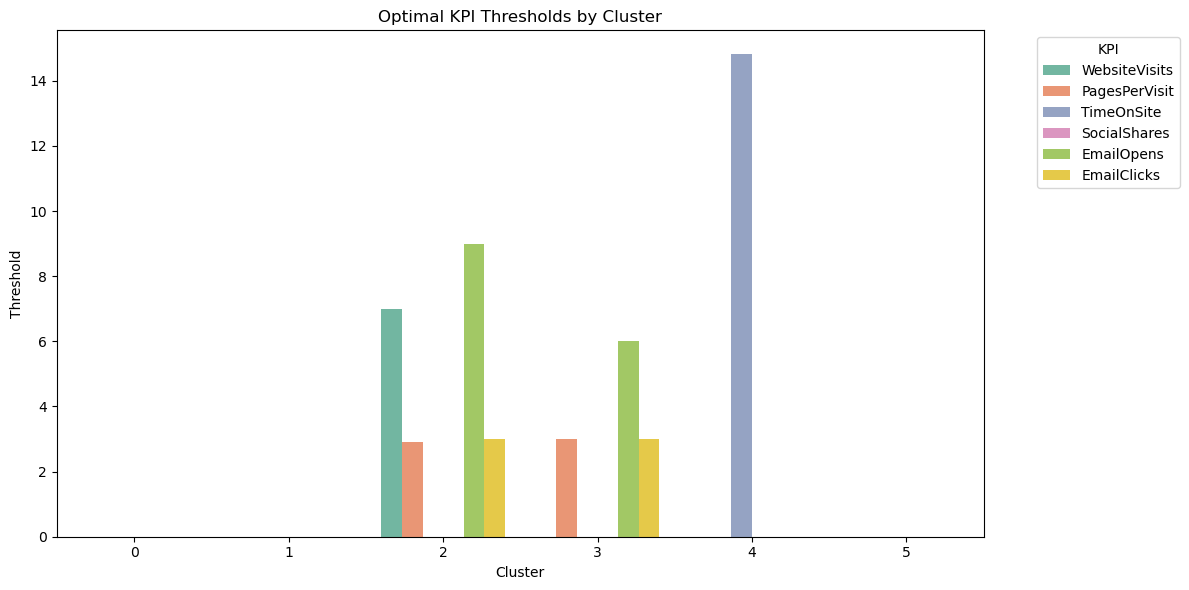

In [17]:
df_plot = new_thresholds_df.reset_index().rename(columns={'index': 'Cluster'})

df_plot['Cluster'] = df_plot['Cluster'].astype(int)
df_plot.sort_values(by='Cluster', inplace=True)

df_melt = pd.melt(df_plot, id_vars=['Cluster'], var_name='KPI', value_name='Threshold')

df_melt['Threshold'] = df_melt['Threshold'].fillna(0)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melt, x='Cluster', y='Threshold', hue='KPI', palette='Set2')
plt.title('Optimal KPI Thresholds by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Threshold')
plt.legend(title='KPI', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("Optimal KPI Thresholds by Cluster.png", format="png", dpi=300)
plt.show()

## Cluster KPI met

In [18]:
def count_kpi_hits(row, thresholds_dict, kpi_list):
    cluster = row['Cluster_Label']
    hit_count = 0
    for kpi in kpi_list:
        threshold = thresholds_dict.get(cluster, {}).get(kpi, np.nan)
        if pd.isna(threshold) or np.isinf(threshold):
            continue
        if row[kpi] >= threshold:
            hit_count += 1
    return hit_count

kpi_columns = ['WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 
               'SocialShares', 'EmailOpens', 'EmailClicks']

df_labels['KPI_hit_count'] = df_labels.apply(lambda row: count_kpi_hits(row, new_cluster_thresholds, kpi_columns), axis=1)

print(df_labels[['Cluster_Label'] + kpi_columns + ['KPI_hit_count']].head())

   Cluster_Label  WebsiteVisits  PagesPerVisit  TimeOnSite  SocialShares  \
0              3              0       2.399017    7.396803            19   
1              2             42       2.917138    5.352549             5   
2              3              2       8.223619   13.794901             0   
3              4             47       4.540939   14.688363            89   
4              4              0       2.046847   13.993370             6   

   EmailOpens  EmailClicks  KPI_hit_count  
0           6            9              2  
1           2            7              3  
2          11            2              2  
3           2            2              0  
4           6            6              0  


## Proportion of KPI met

In [19]:
for kpi, threshold in kpi_thresholds.items():
    df_labels[kpi + '_overall_met'] = (df_labels[kpi] >= threshold).astype(int)

overall_met_cols = [kpi + '_overall_met' for kpi in kpi_thresholds.keys()]
df_labels['Overall_KPI_hit_count'] = df_labels[overall_met_cols].sum(axis=1)

total_overall = len(kpi_thresholds)
df_labels['Overall_KPI_proportion'] = df_labels['Overall_KPI_hit_count'] / total_overall

def compute_cluster_kpi_proportion(row, thresholds_dict, kpi_list):
    cluster = row['Cluster_Label']
    hit_count = 0
    total_valid = 0
    for kpi in kpi_list:
        threshold = thresholds_dict.get(cluster, {}).get(kpi, np.nan)
        if pd.notna(threshold) and not np.isinf(threshold):
            total_valid += 1
            if row[kpi] >= threshold:
                hit_count += 1
    return hit_count / total_valid if total_valid > 0 else np.nan

df_labels['Cluster_KPI_proportion'] = df_labels.apply(
    lambda row: compute_cluster_kpi_proportion(row, new_cluster_thresholds, list(kpi_thresholds.keys())),
    axis=1
)

print(df_labels[['Cluster_Label', 'Overall_KPI_proportion', 'Cluster_KPI_proportion']].head())

   Cluster_Label  Overall_KPI_proportion  Cluster_KPI_proportion
0              3                0.571429                0.666667
1              2                0.714286                0.750000
2              3                0.714286                0.666667
3              4                0.714286                0.000000
4              4                0.714286                0.000000


## Cluster KPI hit count proportion vs Conversion Status

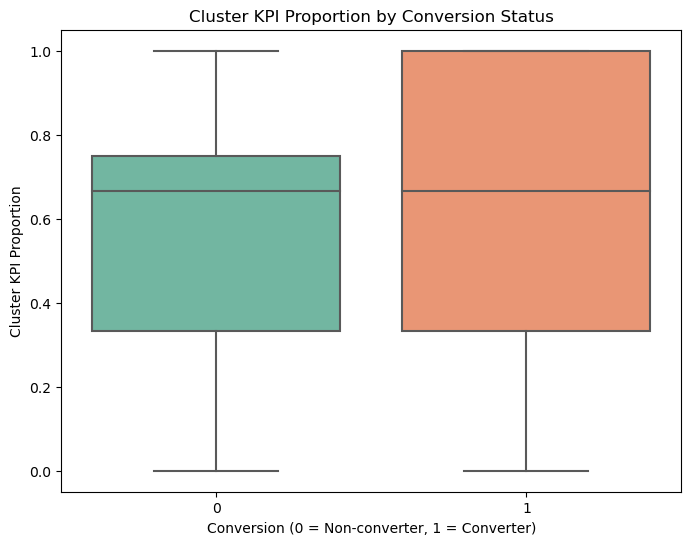

Mean Cluster KPI Proportion for Converters: 0.6056231003039514
Mean Cluster KPI Proportion for Non-Converters: 0.5596846846846847
T-test: t-statistic = 1.777, p-value = 0.077478


In [20]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Conversion', y='Cluster_KPI_proportion', data=df_labels, palette='Set2')
plt.title('Cluster KPI Proportion by Conversion Status')
plt.xlabel('Conversion (0 = Non-converter, 1 = Converter)')
plt.ylabel('Cluster KPI Proportion')
plt.savefig("Cluster KPI Hit Proportion vs Conversion.png", format="png", dpi=300)
plt.show()

mean_conv = df_labels[df_labels['Conversion'] == 1]['Cluster_KPI_proportion'].mean()
mean_nonconv = df_labels[df_labels['Conversion'] == 0]['Cluster_KPI_proportion'].mean()
print("Mean Cluster KPI Proportion for Converters:", mean_conv)
print("Mean Cluster KPI Proportion for Non-Converters:", mean_nonconv)

conv_proportion = df_labels[df_labels['Conversion'] == 1]['Cluster_KPI_proportion'].dropna()
nonconv_proportion = df_labels[df_labels['Conversion'] == 0]['Cluster_KPI_proportion'].dropna()
t_stat, p_val = ttest_ind(conv_proportion, nonconv_proportion, equal_var=False)
print(f"T-test: t-statistic = {t_stat:.3f}, p-value = {p_val:.6f}")

**Analysis and Implications:**

1. **Baseline Similarity:**  
   The similarity at the median and lower quantiles suggests that merely reaching a basic level of engagement (hitting a minimum set of KPIs) is not enough to drive conversion, as both groups start from a similar point.

2. **High Engagement as a Differentiator:**  
   The notably higher upper quartile and whisker for converters indicate that a portion of converters significantly exceed the baseline KPI engagement. This group likely benefits from additional or more effective interactions that propel them well beyond the minimum level, thereby driving conversion.

3. **Strategic Focus:**  
   - **For Non-Converters:**  
     Efforts could focus on lifting the overall engagement beyond the baseline. Since non-converters do not reach the higher engagement levels seen in some converters, targeted strategies to boost engagement (more personalized content, additional touchpoints) could be crucial.
   - **For Converters:**  
     Understanding what differentiates the top performers among converters (the high upper quartile) could provide insights into effective practices or channels. Identifying these best practices may help in designing interventions that encourage more customers to move into this high-engagement group.

In summary, while both converters and non-converters start from a similar baseline of KPI engagement, achieving significantly higher engagement appears to be a key factor that differentiates converters from non-converters.

## overall KPI hit count vs Conversion Status

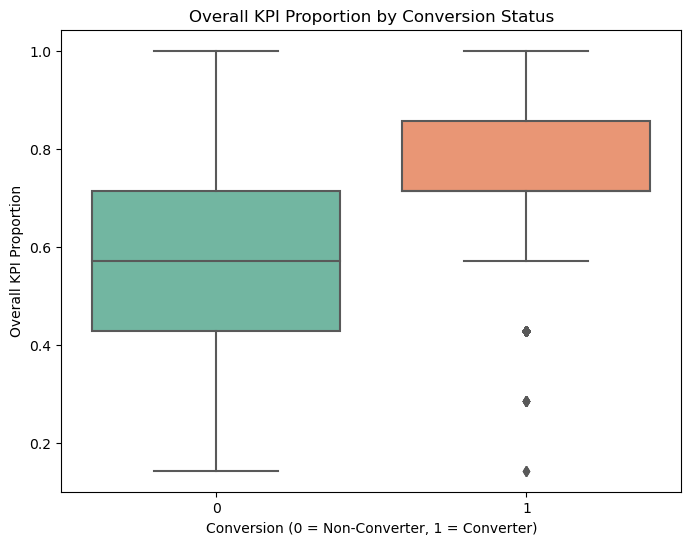

Mean Overall KPI Proportion for Converters: 0.7601254991443239
Mean Overall KPI Proportion for Non-Converters: 0.5657894736842105
T-test: t-statistic = 31.178, p-value = 0.000000


In [21]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Conversion', y='Overall_KPI_proportion', data=df_labels, palette='Set2')
plt.title('Overall KPI Proportion by Conversion Status')
plt.xlabel('Conversion (0 = Non-Converter, 1 = Converter)')
plt.ylabel('Overall KPI Proportion')
plt.savefig("Overall KPI Hit Count vs Conversion.png", format="png", dpi=300)
plt.show()

conv_mean = df_labels[df_labels['Conversion'] == 1]['Overall_KPI_proportion'].mean()
nonconv_mean = df_labels[df_labels['Conversion'] == 0]['Overall_KPI_proportion'].mean()
print("Mean Overall KPI Proportion for Converters:", conv_mean)
print("Mean Overall KPI Proportion for Non-Converters:", nonconv_mean)

conv_data = df_labels[df_labels['Conversion'] == 1]['Overall_KPI_proportion'].dropna()
nonconv_data = df_labels[df_labels['Conversion'] == 0]['Overall_KPI_proportion'].dropna()
t_stat, p_val = ttest_ind(conv_data, nonconv_data, equal_var=False)
print("T-test: t-statistic = {:.3f}, p-value = {:.6f}".format(t_stat, p_val))

Based on the observations, here's an analysis of the boxplot comparing overall KPI hit count by conversion status:

- **Higher Stats for Converters (Except Upper Whisker):**  
  Converters consistently show significantly higher values at the lower whisker, lower quartile, median, and upper quartile compared to non-converters. This indicates that, on average, converters hit more KPIs. Their performance is elevated throughout most of the distribution.

- **Similar Upper Whisker:**  
  The upper whisker, representing the extreme high-end outliers, is roughly the same for both converters and non-converters. This suggests there is a natural or systemic ceiling on the number of KPIs that can be hit, regardless of conversion status. In other words, even though converters generally perform better, the maximum achievable KPI count is comparable across both groups.

**Implications:**

- **Consistent Elevated Engagement:**  
  The overall higher KPI counts in converters indicate that consistently hitting more KPIs is associated with conversion. This suggests that boosting engagement across a range of KPIs might be key to moving customers toward conversion.

- **Ceiling Effect:**  
  The similarity in the upper whisker implies that there might be an upper limit to KPI engagement that both groups can reach. While some non-converters can occasionally hit as many KPIs as converters, it is the overall higher performance across most of the distribution that differentiates converters from non-converters.

- **Focus on Lifting the Distribution:**  
  For non-converters, the strategy might focus on elevating the entire KPI hit distribution rather than chasing the absolute maximum, since reaching that ceiling alone does not ensure conversion.

In summary, converters consistently hit a higher proportion of KPIs across nearly all statistical measures, with the notable exception that the absolute maximum is similar across both groups—highlighting that overall consistency and elevated performance in engaging with KPIs is what most strongly correlates with conversion.

The lower correlation suggests that while the cluster-specific KPI hit proportion provides some insights into engagement within that segment, it may not capture the conversion drivers as effectively as the overall KPI metrics, likely due to reduced variability and sample size effects within each cluster.